## Binary classification with Logistic regression 

### import libraries 

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import pymysql
import getpass

password = getpass.getpass()

········


### connection to sql 

In [6]:
# connection string

connection_string = 'mysql+pymysql://root:'+ password + '@localhost/bank'
engine = create_engine(connection_string)

In [40]:
df=pd.read_sql_query('''
select l.loan_id, l.status, count(distinct t.trans_id) as nooftrans,
DATEDIFF(19981231, convert(a.date,date)) as ageindays, 
d.A12 as 95unemp, d.A13 as 96unemp, dp.type,
l.amount as loanamount, c.birth_number, d.A15 as crime95, d.A16 as crime96,
round((l.amount-l.payments)/l.amount,2) as ratiopaid
from loan l
left join trans t
using(account_id)
left join account a
using(account_id)
left join district d
on a.district_id = d.A1
left join disp dp
on a.account_id= dp.account_id 
left join client c
using(client_id)
where l.status in('A','B') and dp.type='OWNER'
group by loan_id, l.amount, status, d.A12, d.A13, c.birth_number, d.A15, d.A16, DATEDIFF(19981231, convert(a.date,date)),
 dp.type, round((l.amount-l.payments)/l.amount,2)
''', engine)

In [44]:
# use head to confirm the df works as expected 

df.head(10)

,loan_id,status,nooftrans,ageindays,95unemp,96unemp,type,loanamount,birth_number,crime95,crime96,ratiopaid
0,4959,A,374,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96
1,4961,B,259,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92
2,4962,A,225,886,4.09,4.72,OWNER,30276,620209,5623,5887,0.92
3,4973,A,295,1534,1.12,1.54,OWNER,165960,445613,1874,1913,0.96
4,4986,A,209,970,4.75,5.44,OWNER,102876,420128,18782,18347,0.92
5,4996,A,169,964,6.49,7.07,OWNER,88440,455703,6949,6872,0.92
6,5002,A,415,1861,3.51,4.12,OWNER,104808,391130,2247,2103,0.92
7,5005,A,211,871,5.93,5.57,OWNER,27456,670924,4980,4595,0.92
8,5032,A,390,1855,4.69,4.98,OWNER,123696,400827,2854,3158,0.98
9,5045,B,335,1844,5.74,5.72,OWNER,187224,471008,2157,2718,0.96


### EDA - exploratory data analysis - get to know the data 

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loan_id       234 non-null    int64  
 1   status        234 non-null    object 
 2   nooftrans     234 non-null    int64  
 3   ageindays     234 non-null    int64  
 4   95unemp       234 non-null    float64
 5   96unemp       234 non-null    float64
 6   type          234 non-null    object 
 7   loanamount    234 non-null    int64  
 8   birth_number  234 non-null    int64  
 9   crime95       234 non-null    int64  
 10  crime96       234 non-null    int64  
 11  ratiopaid     234 non-null    float64
dtypes: float64(3), int64(7), object(2)
memory usage: 22.1+ KB


In [47]:
df.describe()

,loan_id,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,6233.803419,317.794872,1633.615385,2.867735,3.519487,98143.435897,579128.367521,17469.858974,19639.179487,0.945513
std,680.590147,101.515938,458.123807,1.986507,2.266641,72013.383242,129120.756354,29906.361998,34746.947993,0.023290
min,4959.000000,108.000000,550.000000,0.000000,0.430000,4980.000000,350721.000000,0.000000,888.000000,0.920000
25%,5684.750000,228.250000,1224.250000,1.390000,1.960000,45039.000000,465172.000000,2157.500000,2252.000000,0.920000
50%,6300.000000,336.500000,1847.500000,2.790000,3.600000,80646.000000,580767.000000,3804.000000,3894.000000,0.960000
75%,6756.750000,389.500000,2029.750000,4.090000,4.772500,126960.000000,685783.750000,9878.000000,10108.000000,0.960000
max,7308.000000,548.000000,2178.000000,7.340000,9.400000,464520.000000,805709.000000,85677.000000,99107.000000,0.980000


In [48]:
# check data types & verify if these need to be changed
df.dtypes

loan_id           int64
status           object
nooftrans         int64
ageindays         int64
95unemp         float64
96unemp         float64
type             object
loanamount        int64
birth_number      int64
crime95           int64
crime96           int64
ratiopaid       float64
dtype: object

In [49]:
df.birth_number.unique()

array([450204, 395423, 620209, 445613, 420128, 455703, 391130, 670924,
       400827, 471008, 421210, 405212, 565913, 510806, 556119, 610930,
       480521, 775510, 455612, 636231, 686220, 466017, 411111, 570429,
       755912, 575122, 405724, 475722, 680722, 405420, 570919, 635125,
       765609, 391206, 406204, 766012, 745620, 430104, 655716, 666210,
       400326, 706007, 790214, 805709, 565425, 400907, 581007, 626228,
       506020, 670210, 395315, 720206, 655604, 361223, 571101, 521128,
       641016, 525726, 351225, 515625, 456227, 540309, 575628, 635204,
       760916, 495624, 406101, 680506, 595810, 455908, 490724, 466007,
       515407, 565313, 675529, 610502, 715920, 350721, 726227, 640313,
       735515, 705912, 596122, 680909, 520717, 795406, 351003, 510410,
       631012, 805430, 536225, 406015, 561230, 495308, 575127, 721203,
       700428, 485812, 786121, 530618, 431126, 620523, 790326, 636224,
       680129, 570929, 640513, 620911, 575906, 705210, 406202, 380916,
      

### histograms or boxplots



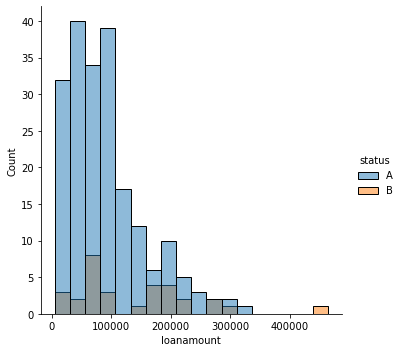

In [50]:
sns.displot(df, x = 'loanamount', hue = 'status');

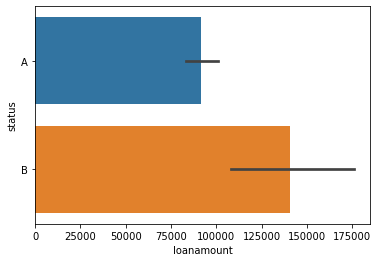

In [51]:
sns.barplot(x = 'loanamount', y = 'status', data = df);

In [52]:
df['status'].value_counts()

A    203
B     31
Name: status, dtype: int64

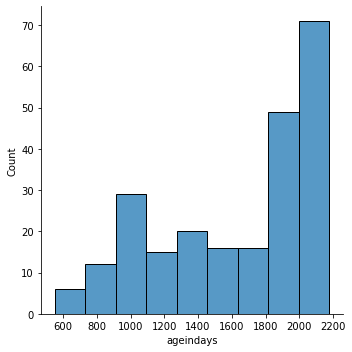

In [54]:
sns.displot(df['ageindays']);

### Check for multicollinearity 

In [55]:
correlation = df.corr()
correlation

,loan_id,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
loan_id,1.000000,0.108456,0.077547,-0.083545,-0.078858,0.082673,0.151662,0.144176,0.143709,0.120034
nooftrans,0.108456,1.000000,0.896726,-0.107024,-0.142902,0.200899,0.085988,0.061994,0.062902,0.353508
ageindays,0.077547,0.896726,1.000000,-0.159444,-0.194317,0.278373,0.065923,0.066678,0.067470,0.439152
95unemp,-0.083545,-0.107024,-0.159444,1.000000,0.953504,-0.012914,0.055640,-0.534407,-0.540018,-0.049599
96unemp,-0.078858,-0.142902,-0.194317,0.953504,1.000000,-0.009944,0.041388,-0.568564,-0.572576,-0.050709
loanamount,0.082673,0.200899,0.278373,-0.012914,-0.009944,1.000000,0.008705,-0.007111,-0.005546,0.596621
birth_number,0.151662,0.085988,0.065923,0.055640,0.041388,0.008705,1.000000,-0.019644,-0.019462,0.034583
crime95,0.144176,0.061994,0.066678,-0.534407,-0.568564,-0.007111,-0.019644,1.000000,0.999728,0.018829
crime96,0.143709,0.062902,0.067470,-0.540018,-0.572576,-0.005546,-0.019462,0.999728,1.000000,0.020247
ratiopaid,0.120034,0.353508,0.439152,-0.049599,-0.050709,0.596621,0.034583,0.018829,0.020247,1.000000


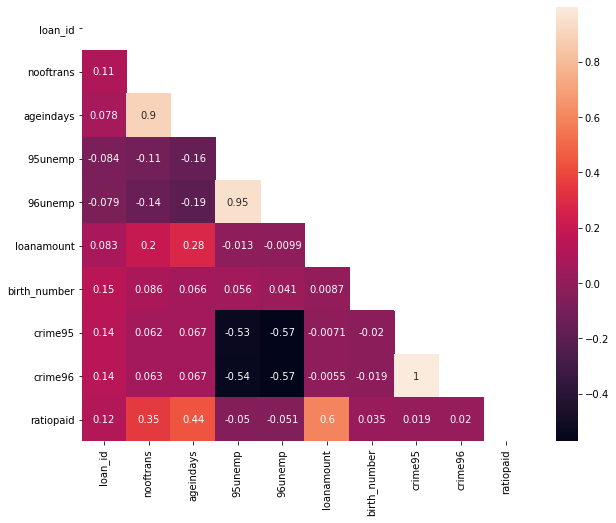

In [62]:
corr_matrix = df.corr(method = 'pearson')
fig, ax = plt.subplots (figsize = (10,8))
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
ax = sns.heatmap(corr_matrix, mask = mask, annot = True)
plt.show()

### Clean and wrangling steps 

In [ ]:
# clean /wrangling steps suggested :
# bucket into categories any fields 
# should we drop any columns ? (iterative process)
# extract gender from birth_number
# data type changes 
#drop highly correlated features 
#create avg of criminality / unempl rate 
# crime - divide by population 
# bring in any missing fields 
# change unempl into HML 
# change crime numbers into one column - sum the two columns 
#bring in the C and D statuses - and then using a function map to good or bad 
# OR multi class regression ?
# k symbol might be worth including 
# loan duration 

#feature engineering - take the columns and make more useful 



# split the data into num and cat --- > diff options cleaning / scaling

In [63]:
df.drop(['loan_id', 'type'], axis = 1, inplace = True)

In [64]:
df.head()

,status,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
0,A,374,2134,0.29,0.43,80952,450204,85677,99107,0.96
1,B,259,1364,1.51,2.07,30276,395423,2299,2354,0.92
2,A,225,886,4.09,4.72,30276,620209,5623,5887,0.92
3,A,295,1534,1.12,1.54,165960,445613,1874,1913,0.96
4,A,209,970,4.75,5.44,102876,420128,18782,18347,0.92


### Pre processing 

In [ ]:
# label / encode categorical columns 

# scale numerical columns 



In [69]:
# categorical data

cat = df.select_dtypes(include = object)
cat.head()

,status
0,A
1,B
2,A
3,A
4,A


In [72]:
categorical = pd.get_dummies(cat, columns = ['status'], drop_first = True)
categorical.head()

,status_B
0,0
1,1
2,0
3,0
4,0


In [73]:
# numerical scaling

from sklearn.preprocessing import Normalizer

In [76]:
# select numerical features

x = df.select_dtypes(include = np.number)

In [80]:
x.head()

,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
0,374,2134,0.29,0.43,80952,450204,85677,99107,0.96
1,259,1364,1.51,2.07,30276,395423,2299,2354,0.92
2,225,886,4.09,4.72,30276,620209,5623,5887,0.92
3,295,1534,1.12,1.54,165960,445613,1874,1913,0.96
4,209,970,4.75,5.44,102876,420128,18782,18347,0.92


In [83]:
# scaling the data set to gaussian distribution
# once scaled, we convert the array back to a dataframe

scaler = Normalizer().fit(x)
scaled = scaler.transform(x)
scaled_x = pd.DataFrame(scaled)
scaled_x.head()

,0,1,2,3,4,5,6,7,8
0,0.000786,0.004485,6.094747e-07,9.037038e-07,0.170132,0.946165,0.180062,0.208287,0.000002
1,0.000653,0.003439,3.807397e-06,5.219411e-06,0.076340,0.997041,0.005797,0.005936,0.000002
2,0.000362,0.001427,6.586135e-06,7.600625e-06,0.048753,0.998724,0.009055,0.009480,0.000001
3,0.000620,0.003226,2.355295e-06,3.238531e-06,0.349004,0.937098,0.003941,0.004023,0.000002
4,0.000482,0.002238,1.096143e-05,1.255373e-05,0.237404,0.969517,0.043343,0.042339,0.000002


In [ ]:
# if we would have more categorical features at hand than just status we would concat

# x = np.concatenate((scaled_x, categorical), axis = 1)

### split off the dependant variable (label)

In [86]:
# y = dependent variable - status - binary

y = categorical['status_B']

# independent variables are scaled_x

X = scaled_x

In [85]:
y

0      0
1      1
2      0
3      0
4      0
      ..
229    0
230    0
231    0
232    0
233    0
Name: status_B, Length: 234, dtype: uint8

In [87]:
X.head()

,0,1,2,3,4,5,6,7,8
0,0.000786,0.004485,6.094747e-07,9.037038e-07,0.170132,0.946165,0.180062,0.208287,0.000002
1,0.000653,0.003439,3.807397e-06,5.219411e-06,0.076340,0.997041,0.005797,0.005936,0.000002
2,0.000362,0.001427,6.586135e-06,7.600625e-06,0.048753,0.998724,0.009055,0.009480,0.000001
3,0.000620,0.003226,2.355295e-06,3.238531e-06,0.349004,0.937098,0.003941,0.004023,0.000002
4,0.000482,0.002238,1.096143e-05,1.255373e-05,0.237404,0.969517,0.043343,0.042339,0.000002


### train test split, get LOG REG model

In [88]:
from sklearn.linear_model import LogisticRegression 

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 40)

## apply model and train model 

In [91]:
classification = LogisticRegression(solver = 'liblinear', multi_class = 'ovr').fit(X_train, y_train)

In [ ]:
# add to the parameters as wished


### evaluate accuracy and test 

In [97]:
# tpr - true positive rate
# fpr - false positive rate
# auc - area under the curve

probabilities = classification.predict_proba(X_test)
preds = probabilities[:,1]
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.7817460317460317


#### next steps

+ Visualise the accuracy of the predictions in some ways 

+ also think about - is there something I could do to improve my model accuracy?? 

### visualising accuracy - ROC / AUC 

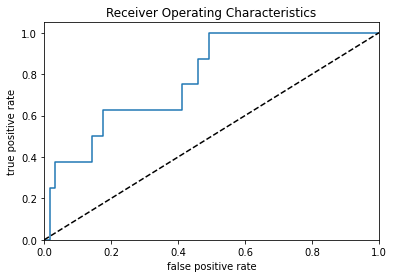

In [103]:
plt.title('Receiver Operating Characteristics')
plt.plot(fpr,tpr, label = 'AUC'%roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()

### visualising accuracy - Confusion Matrix

##### definitions 
+ tpr = true positive rate 
+ fpr = false positive rate

In [111]:
from sklearn.metrics import accuracy_score

predictions = classification.predict(X_test)

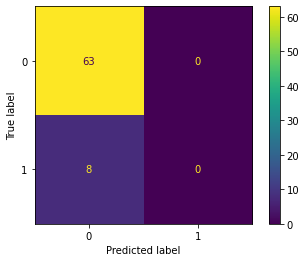

In [112]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

accuracy_score(y_test, predictions)
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)
plt.show()

### data is highly imbalanced

this is affecting the accuracy of our predictions 
- what can be done to resolve that ?


+ option 1 - SMOTE 

+ option 2 - TOMEK LINKS 

